# ИДЗ. Вариант 4
Выполнили Евсеев Евгений, Парахин Николай и Тимофей Тихонов
Группа: БПИ 212

# Условие
## Входные данные

- recid – 1, если заключенный – рецидивист, то есть совершил повторное преступление, 0 иначе
- age – возраст заключенного в месяцах
- black – 1, если преступник – представитель негроидной расы, 0 иначе
- married – 1, если преступник женат, 0 иначе
- alcohol – 1, если у заключенного проблемы с алкоголем, 0 иначе
- drugs – 1, если у заключенного проблемы с наркотиками, 0 иначе
- felon – 1 если приговор за тяжкое преступление
- educ – количество лет школьного образования
- rules – количество нарушений правил в тюрьме

В каждом варианте значение переменная recid известно во всех наблюдениях, кроме последних 50. Эти наблюдения оставлены для прогноза (будем считать, что это преступники, еще не совершившие рецидив).

## Переменные рассматриваемые в задании
- recid – объясняемая переменная
- age, black, married, alcohol, rules - регрессоры

## Рекомендации
Можно из непрерывных переменных educ и rules сконструировать dummy-переменные и ввести их в модель.

*При этом не забываем, что в модель включаем только любые 2 из 3 dummy-переменных (например, age_22 и age_30), чтобы не возникло мультиколлинеарности в данных.*

## Задание

1) Оцените три модели, связывающую вероятность повторного преступления с остальными признаками:
    1) линейную, 
    2) логит, 
    3) пробит.

2) Дайте словесное описание полученных результатов на примере логит-модели. Какие из переменных получились значимыми? Выпишите оцененную ковариационную матрицу оценок коэффициентов.

3) По каждой модели рассчитайте оцените вероятность повторного преступления для всех наблюдений, включая 50 последних (где неизвестно значение recid). Есть ли заметные различия между прогнозируемыми вероятностями? В каких наблюдениях возникают наибольшие расхождения? Кому из ещё не совершивших рецидива бывших заключенных требуется уделить особое внимание?
4) На примере probit модели проверьте значимость модели в целом тестом отношения правдоподобия. Рассчитайте p-значение.
̂5) Этот пункт сделайте для probit модели. Рассмотрим прогнозное правило типа 𝑙𝑜𝑤𝑖 = 1,
если 𝑃(𝑙𝑜𝑤𝑖 = 1) > 𝑐 , иначе 𝑙𝑜𝑤𝑖 = 0 , где c – некое пороговое значение для
моделируемой вероятности. 
Чувствительностью называется доля верных прогнозов среди всех наблюдений, где 𝑙𝑜𝑤𝑖 = 1(способность модели правильно предсказывать «единички»).
Специфичностью называется доля верных прогнозов среди всех наблюдений, где 𝑙𝑜𝑤𝑖 = 0 (способность модели правильно предсказывать «нули»). Рассчитайте чувствительность и специфичность для разных пороговых значений c от 0 до 1, постройте график зависимости чувствительности и специфичности от c.
Требуется, чтобы прогнозная модель имела чувствительность не ниже 80%. Каким должен быть порог c? Какой специфичности можно добиться в этом случае?

In [33]:
import statsmodels.api as sm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats.distributions import chi2

# Шаг 0. Получение данных и конструирование dummy-переменных

In [34]:
# Data import
data = pd.read_csv('data/data_v4.csv', sep=';')
data = data.astype(float)
data.describe()

,recid,black,alcohol,drugs,married,felon,educ,rules,age
count,963.000000,1013.000000,1013.000000,1013.000000,1013.000000,1013.000000,1013.000000,1013.000000,1013.000000
mean,0.395639,0.467917,0.220138,0.238894,0.261599,0.313919,9.720632,1.229023,342.304047
std,0.489242,0.499216,0.414544,0.426619,0.439723,0.464313,2.396048,2.395414,120.245419
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,198.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,0.000000,256.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,10.000000,0.000000,303.000000
75%,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,11.000000,1.000000,388.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,18.000000,27.000000,933.000000


Любопытства ради, для начала, посмотрим на распределение значение по которым мы собираемся строить dummy-переменны.

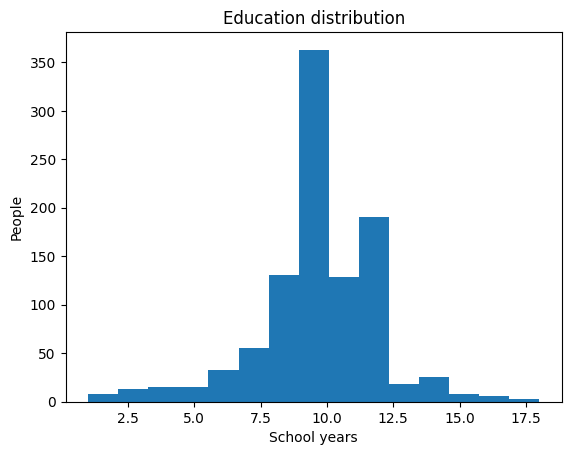

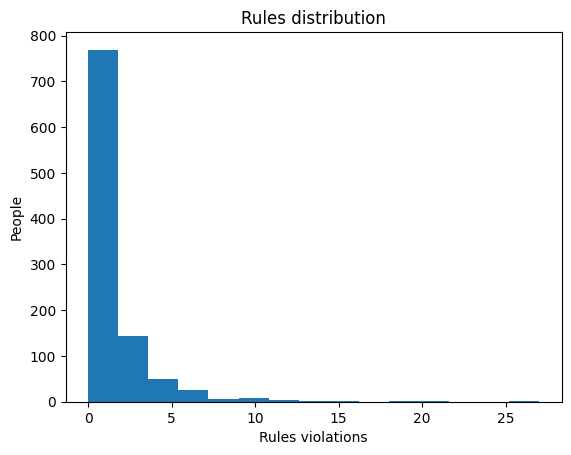

In [35]:
BINS_COUNT = 15

plt.hist(data['educ'], bins=BINS_COUNT)
plt.title('Education distribution')
plt.ylabel('People')
plt.xlabel('School years')
plt.show()

plt.hist(data['rules'], bins=BINS_COUNT)
plt.ylabel('People')
plt.xlabel('Rules violations')
plt.title('Rules distribution')
plt.show()

plt.show()

Сами же переменные будем строить с использованием квантилей, чтобы получить равные группы по количеству наблюдений.
Выделим группы.

In [36]:
GROUPS_COUNT = 3  # Count of groups for each variable

educ_bounds = [0]  # Bounds for education
for i in range(1, GROUPS_COUNT + 1):
    educ_bounds.append(data['educ'].quantile(i / GROUPS_COUNT))

rules_bounds = [0]  # Bounds for rules
for i in range(1, GROUPS_COUNT + 1):
    rules_bounds.append(data['rules'].quantile(i / GROUPS_COUNT))

# TODO: fix
rules_bounds[1] = 0.01  # Fix for 0 values

print("Education bounds", educ_bounds)
print("Rules bounds", rules_bounds)

Education bounds [0, 9.0, 11.0, 18.0]
Rules bounds [0, 0.01, 1.0, 27.0]


Построим dummy-переменные по нашим данным.

In [37]:
# TODO: make right bound +inf

# Education
educ_dummies = pd.get_dummies(pd.cut(data['educ'], educ_bounds, include_lowest=True))
educ_dummies_names = ['educ_' + str(educ_bounds[i]) for i in range(len(educ_bounds) - 1)]
educ_dummies = educ_dummies.astype(int)
educ_dummies.columns = educ_dummies_names
display(educ_dummies.describe())

# Rules
rules_dummies = pd.get_dummies(pd.cut(data['rules'], rules_bounds, include_lowest=True))
rules_dummies_names = ['rules_' + str(rules_bounds[i]) for i in range(len(rules_bounds) - 1)]
rules_dummies = rules_dummies.astype(int)
rules_dummies.columns = rules_dummies_names
display(rules_dummies.describe())

,educ_0,educ_9.0,educ_11.0
count,1013.000000,1013.000000,1013.000000
mean,0.433366,0.318855,0.247779
std,0.495785,0.466263,0.431936
min,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000
75%,1.000000,1.000000,0.000000
max,1.000000,1.000000,1.000000


,rules_0,rules_0.01,rules_1.0
count,1013.000000,1013.000000,1013.000000
mean,0.544916,0.214215,0.240869
std,0.498224,0.410479,0.427822
min,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000
50%,1.000000,0.000000,0.000000
75%,1.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000


# Шаг 1. Построение моделей

- X - матрица объясняющих переменных
- Y - вектор зависимой переменной

- X_test - матрица объясняющих переменных для тестовой выборки
- Y_test - вектор зависимой переменной для тестовой выборки

In [38]:
DATA_NEEDED = data[['recid', 'age', 'black', 'married', 'alcohol']]

X = pd.concat([DATA_NEEDED, educ_dummies.drop(educ_dummies.columns[1], axis=1),
               rules_dummies.drop(rules_dummies.columns[1], axis=1)], axis=1)
X = X.drop(['recid'], axis=1)
X = sm.add_constant(X)
Y = data['recid']

Y_test = Y  # note: last 50 values are NaN
X_test = X

Y = Y.dropna()
X = X[:Y.size]

assert len(X) == len(Y), f'X and Y must have same length, but X has {len(X)} and Y has {len(Y)}'

## Линейная модель
- 𝑌𝑖 = 𝛽0 + 𝛽1𝑋1𝑖 + 𝛽2𝑋2𝑖 + … + 𝛽𝑘𝑋𝑘𝑖 + 𝜀𝑖

- Dep. Variable (зависимая переменная) - `recid`
- Model (модель) - `линейная регрессия`
- Method (метод) - `метод наименьших квадратов`
- No. Observations (количество наблюдений) - `963`
- Df Residuals (степени свободы остатков) - `953`
print(lr_model.summary())
- Df Model (степени свободы модели) - `8` (`const`, `age`, `black`, `married`, `alcohol`, `educ_0`, `educ_11.0`, `rules_0`, `rules_1.0`)
- R-squared (коэффициент детерминации) - `0.064`.
- Adj. R-squared (скорректированный коэффициент детерминации) - `0.056`
- F-statistic (F-статистика) - `8.124`
- Prob (F-статистики) - `1.16e-10` (указывает на статистическую значимость модели в целом)
- Log-Likelihood (логарифмическая функция правдоподобия) - `-645.76`


In [39]:
# Linear regression
lr_model = sm.OLS(Y, X).fit()
print(lr_model.summary())

                            OLS Regression Results                            
Dep. Variable:                  recid   R-squared:                       0.064
Model:                            OLS   Adj. R-squared:                  0.056
Method:                 Least Squares   F-statistic:                     8.124
Date:                Mon, 12 Jun 2023   Prob (F-statistic):           1.16e-10
Time:                        18:39:35   Log-Likelihood:                -645.76
No. Observations:                 963   AIC:                             1310.
Df Residuals:                     954   BIC:                             1353.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.4468      0.060      7.506      0.0

Посчитаем модель Logit

In [40]:
# Logit
lg_model = sm.Logit(Y, X).fit()
print(lg_model.summary())

Optimization terminated successfully.
         Current function value: 0.638539
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:                  recid   No. Observations:                  963
Model:                          Logit   Df Residuals:                      954
Method:                           MLE   Df Model:                            8
Date:                Mon, 12 Jun 2023   Pseudo R-squ.:                 0.04867
Time:                        18:39:35   Log-Likelihood:                -614.91
converged:                       True   LL-Null:                       -646.37
Covariance Type:            nonrobust   LLR p-value:                 1.246e-10
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.1849      0.268     -0.690      0.490      -0.710       0.340
age           -0.0016      0.

Посчитаем модель Probit

In [41]:
# Probit
pr_model = sm.Probit(Y, X).fit()
print(pr_model.summary())

Optimization terminated successfully.
         Current function value: 0.638493
         Iterations 5
                          Probit Regression Results                           
Dep. Variable:                  recid   No. Observations:                  963
Model:                         Probit   Df Residuals:                      954
Method:                           MLE   Df Model:                            8
Date:                Mon, 12 Jun 2023   Pseudo R-squ.:                 0.04873
Time:                        18:39:35   Log-Likelihood:                -614.87
converged:                       True   LL-Null:                       -646.37
Covariance Type:            nonrobust   LLR p-value:                 1.198e-10
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.1238      0.164     -0.755      0.450      -0.445       0.198
age           -0.0009      0.

# Шаг 2. писание полученных результатов на примере логит-модели

In [42]:
print(lg_model.summary())

                           Logit Regression Results                           
Dep. Variable:                  recid   No. Observations:                  963
Model:                          Logit   Df Residuals:                      954
Method:                           MLE   Df Model:                            8
Date:                Mon, 12 Jun 2023   Pseudo R-squ.:                 0.04867
Time:                        18:39:35   Log-Likelihood:                -614.91
converged:                       True   LL-Null:                       -646.37
Covariance Type:            nonrobust   LLR p-value:                 1.246e-10
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.1849      0.268     -0.690      0.490      -0.710       0.340
age           -0.0016      0.001     -2.425      0.015      -0.003      -0.000
black          0.5502      0.140      3.919      0.0

## Значимые переменные
Уровень значимости - 0.05

In [43]:
SL = 0.05
display(lg_model.pvalues[lg_model.pvalues < SL])

age          0.015307
black        0.000089
alcohol      0.000467
rules_0      0.043395
rules_1.0    0.015127
dtype: float64

## Ковариационная матрица и корреляционная матрица

In [44]:
cov_matrix = lg_model.cov_params()
print('Covariance matrix')
display(cov_matrix)

# Find correlation matrix
corr_matrix = cov_matrix / np.outer(np.sqrt(np.diag(cov_matrix)), np.sqrt(np.diag(cov_matrix)))
print('Correlation matrix')
display(corr_matrix)

# Find most correlated variables
CORR_THRESHOLD = 0.2
corr_matrix_peeks = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
corr_matrix_peeks = corr_matrix_peeks.unstack().sort_values(ascending=False)
corr_matrix_peeks = corr_matrix_peeks[(corr_matrix_peeks > CORR_THRESHOLD) | (corr_matrix_peeks < -CORR_THRESHOLD)]
corr_matrix_peeks = corr_matrix_peeks.drop_duplicates()
corr_matrix_peeks = corr_matrix_peeks.to_frame()
corr_matrix_peeks.columns = ['Correlation']
print('Most correlated variables')
display(corr_matrix_peeks)

Covariance matrix


,const,age,black,married,alcohol,educ_0,educ_11.0,rules_0,rules_1.0
const,0.071762,-1.137622e-04,-0.011561,1.214910e-04,0.001016,-0.010679,-1.245698e-02,-0.018460,-0.024105
age,-0.000114,4.143880e-07,-0.000005,-2.168077e-05,-0.000025,-0.000017,-1.357773e-05,-0.000006,0.000006
black,-0.011561,-4.632253e-06,0.019713,8.000318e-04,0.003163,0.004398,1.945243e-03,-0.000071,0.000933
married,0.000121,-2.168077e-05,0.000800,2.668565e-02,-0.001660,-0.000557,3.234015e-07,0.000933,0.001440
alcohol,0.001016,-2.519844e-05,0.003163,-1.659814e-03,0.028670,0.000787,7.577476e-04,-0.002093,0.000702
educ_0,-0.010679,-1.748153e-05,0.004398,-5.571111e-04,0.000787,0.026539,1.506965e-02,-0.000942,-0.000884
educ_11.0,-0.012457,-1.357773e-05,0.001945,3.234015e-07,0.000758,0.015070,3.472780e-02,0.001142,0.002414
rules_0,-0.018460,-6.316668e-06,-0.000071,9.330396e-04,-0.002093,-0.000942,1.142350e-03,0.030183,0.020825
rules_1.0,-0.024105,5.888824e-06,0.000933,1.440416e-03,0.000702,-0.000884,2.414259e-03,0.020825,0.039482


Correlation matrix


,const,age,black,married,alcohol,educ_0,educ_11.0,rules_0,rules_1.0
const,1.000000,-0.659699,-0.307368,0.002776,0.022400,-0.244700,-0.249532,-0.396652,-0.452864
age,-0.659699,1.000000,-0.051252,-0.206173,-0.231182,-0.166698,-0.113184,-0.056481,0.046039
black,-0.307368,-0.051252,1.000000,0.034881,0.133045,0.192266,0.074346,-0.002927,0.033442
married,0.002776,-0.206173,0.034881,1.000000,-0.060007,-0.020934,0.000011,0.032876,0.044376
alcohol,0.022400,-0.231182,0.133045,-0.060007,1.000000,0.028513,0.024014,-0.071147,0.020851
educ_0,-0.244700,-0.166698,0.192266,-0.020934,0.028513,1.000000,0.496386,-0.033299,-0.027320
educ_11.0,-0.249532,-0.113184,0.074346,0.000011,0.024014,0.496386,1.000000,0.035284,0.065200
rules_0,-0.396652,-0.056481,-0.002927,0.032876,-0.071147,-0.033299,0.035284,1.000000,0.603272
rules_1.0,-0.452864,0.046039,0.033442,0.044376,0.020851,-0.027320,0.065200,0.603272,1.000000


Most correlated variables


,,Correlation
rules_1.0,rules_0,0.603272
educ_11.0,educ_0,0.496386
married,age,-0.206173
alcohol,age,-0.231182
educ_0,const,-0.244700
educ_11.0,const,-0.249532
black,const,-0.307368
rules_0,const,-0.396652
rules_1.0,const,-0.452864
age,const,-0.659699


# Шаг 3. Расчет прогнозных значений


In [45]:
lr_model_pred = lr_model.predict(X_test)
lg_model_pred = lg_model.predict(X_test)
pr_model_pred = pr_model.predict(X_test)

print('Results of predictions for last 50 values')
print('Linear regression predictions')
display(lr_model_pred[Y.size:])

print('Logit predictions')
display(lg_model_pred[Y.size:])

print('Probit predictions')
display(pr_model_pred[Y.size:])

Results of predictions for last 50 values
Linear regression predictions


963     0.483169
964     0.499498
965     0.240278
966     0.603706
967     0.301777
968     0.325531
969     0.479382
970     0.405081
971     0.515160
972     0.408236
973     0.552216
974     0.200118
975     0.421699
976     0.407574
977     0.349016
978     0.385065
979     0.454460
980     0.620918
981     0.516815
982     0.310714
983     0.258232
984     0.366655
985     0.309311
986     0.537983
987     0.385065
988     0.416190
989     0.412870
990     0.403686
991     0.314608
992     0.443516
993     0.234085
994     0.416469
995     0.520973
996     0.439361
997     0.408898
998     0.394029
999     0.139084
1000    0.436408
1001    0.515822
1002    0.321890
1003    0.396678
1004    0.285044
1005    0.464301
1006    0.432079
1007    0.291885
1008    0.497616
1009    0.445796
1010    0.331100
1011    0.287692
1012    0.510195
dtype: float64

Logit predictions


963     0.479625
964     0.496190
965     0.244570
966     0.610156
967     0.293782
968     0.322497
969     0.483622
970     0.397106
971     0.516187
972     0.405618
973     0.555207
974     0.210073
975     0.419233
976     0.404865
977     0.343133
978     0.379567
979     0.457932
980     0.629283
981     0.518136
982     0.302602
983     0.256192
984     0.360979
985     0.306016
986     0.538574
987     0.379567
988     0.413014
989     0.410897
990     0.402594
991     0.311346
992     0.440474
993     0.238316
994     0.415451
995     0.531471
996     0.439733
997     0.406371
998     0.392163
999     0.166594
1000    0.432863
1001    0.516967
1002    0.318757
1003    0.395144
1004    0.281019
1005    0.457472
1006    0.431291
1007    0.289783
1008    0.495509
1009    0.438866
1010    0.324745
1011    0.283550
1012    0.510337
dtype: float64

Probit predictions


963     0.480043
964     0.496732
965     0.243411
966     0.609173
967     0.294627
968     0.321688
969     0.483134
970     0.401325
971     0.515165
972     0.405861
973     0.555648
974     0.208186
975     0.419013
976     0.405138
977     0.344830
978     0.380749
979     0.456198
980     0.627667
981     0.517025
982     0.303372
983     0.256316
984     0.360528
985     0.305481
986     0.539758
987     0.380749
988     0.415041
989     0.410934
990     0.400960
991     0.310733
992     0.442164
993     0.235676
994     0.415590
995     0.529032
996     0.440664
997     0.406585
998     0.391837
999     0.161564
1000    0.433699
1001    0.515909
1002    0.318018
1003    0.394708
1004    0.281236
1005    0.458891
1006    0.432579
1007    0.289202
1008    0.495441
1009    0.440548
1010    0.327074
1011    0.283760
1012    0.509585
dtype: float64

Найдем дисперсию остатоков

Linear Regression D:	0.22385795185446292
Logit D:	0.22389577297113403
Probit D:	0.22388364706264352


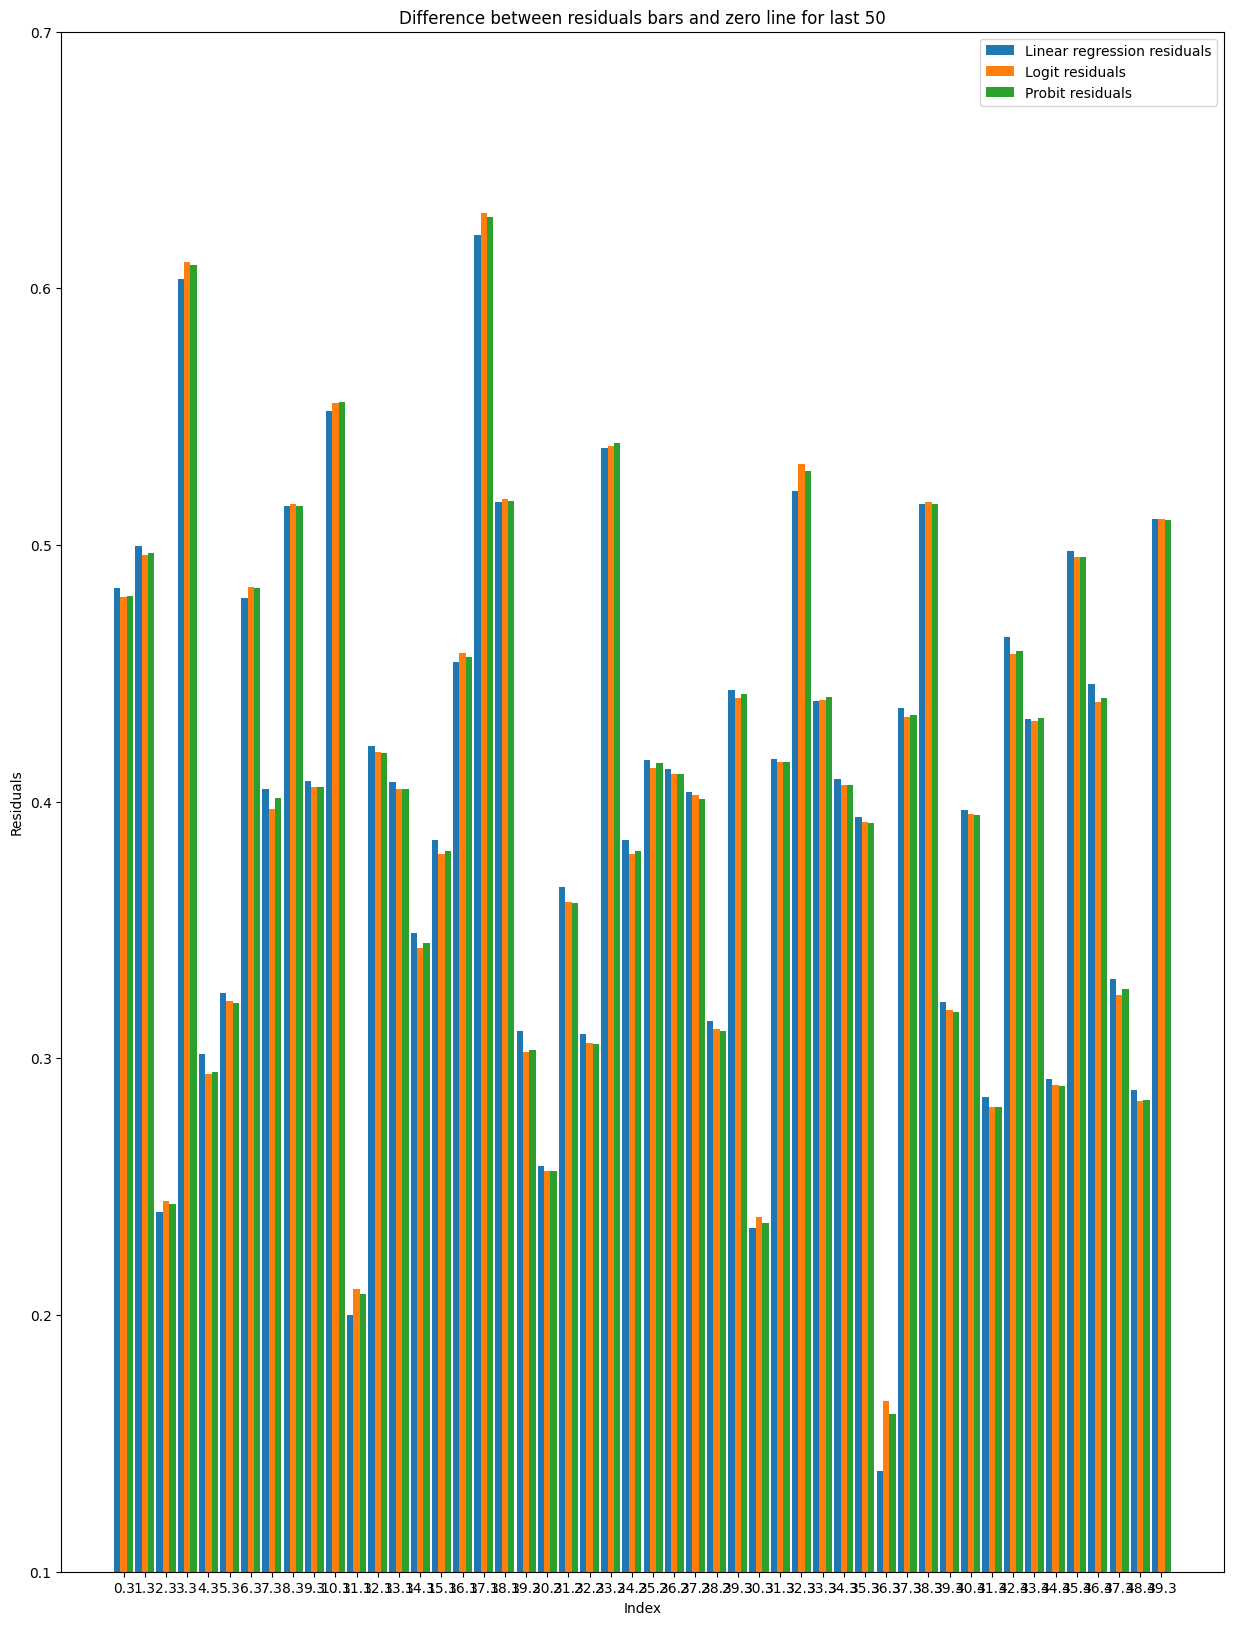

In [46]:
lr_residuals = Y - lr_model_pred[:Y.size]
lg_residuals = Y - lg_model_pred[:Y.size]
pr_residuals = Y - pr_model_pred[:Y.size]

# Dispersion of residuals
print('Linear Regression D:', np.var(lr_residuals), sep='\t')
print('Logit D:', np.var(lg_residuals), sep='\t')
print('Probit D:', np.var(pr_residuals), sep='\t')

# Plot show difference between residuals group bars  and zero line for last 50
plt.figure(figsize=(15, 20))
bar_width = 0.3
plt.bar(np.arange(50), lr_model_pred[-50:], bar_width, label='Linear regression residuals')
plt.bar(np.arange(50) + bar_width, lg_model_pred[-50:], bar_width, label='Logit residuals')
plt.bar(np.arange(50) + 2 * bar_width, pr_model_pred[-50:], bar_width, label='Probit residuals')
plt.ylim(0.1, 0.7)
plt.xticks(np.arange(50) + bar_width)

plt.title('Difference between residuals bars and zero line for last 50')
plt.xlabel('Index')
plt.ylabel('Residuals')

plt.legend()
plt.show()





In [47]:
DF_V_ABS_SL = 0.04
residuals_max_diff = []

for i in range(Y.size):
    diff_1 = abs(lr_residuals[i] - lg_residuals[i])
    diff_2 = abs(lr_residuals[i] - pr_residuals[i])
    diff_3 = abs(lg_residuals[i] - pr_residuals[i])

    if any(pd.Series([diff_1, diff_2, diff_3]) > DF_V_ABS_SL):
        residuals_max_diff.append([i, max(diff_1, diff_2, diff_3), diff_1, diff_2, diff_3])

residuals_max_diff = pd.DataFrame(residuals_max_diff, columns=['Index', 'max_diff', 'LR-LG', 'LR-PR', 'LG-PR']).astype({'Index': int}).set_index('Index')
residuals_max_diff.index.name = None

print('Predictions with residuals difference more than', DF_V_ABS_SL, 'between models')
# union with X
residuals_max_diff = residuals_max_diff.join(Y).join(X)

display(residuals_max_diff)


Predictions with residuals difference more than 0.04 between models


,max_diff,LR-LG,LR-PR,LG-PR,recid,const,age,black,married,alcohol,educ_0,educ_11.0,rules_0,rules_1.0
236,0.055293,0.055293,0.047578,0.007715,0.0,1.0,611.0,0.0,1.0,0.0,0,1,1,0
267,0.042204,0.042204,0.035620,0.006584,0.0,1.0,520.0,0.0,1.0,0.0,0,1,1,0
417,0.048891,0.048891,0.041713,0.007178,0.0,1.0,568.0,0.0,1.0,0.0,0,1,1,0
586,0.047320,0.047320,0.041448,0.005872,1.0,1.0,720.0,0.0,0.0,0.0,0,1,1,0
756,0.049962,0.049962,0.042810,0.007152,0.0,1.0,799.0,0.0,1.0,0.0,1,0,1,0
867,0.053172,0.053172,0.045703,0.007469,0.0,1.0,726.0,0.0,1.0,0.0,0,0,1,0


Найдем людей с наибольшим отклонением от

In [48]:
most_influential = set()

# For lr. lg. pr
sorted_lr_residuals = np.argsort(np.abs(lr_residuals))
sorted_lg_residuals = np.argsort(np.abs(lg_residuals))
sorted_pr_residuals = np.argsort(np.abs(pr_residuals))

most_influential = most_influential.union([*sorted_lr_residuals[-15:]])
most_influential = most_influential.union([*sorted_lg_residuals[-15:]])
most_influential = most_influential.union([*sorted_pr_residuals[-15:]])

most_influential = list(most_influential)
print(most_influential)

predictions = pd.DataFrame({'lr': lr_model_pred, 'lg': lg_model_pred, 'pr': pr_model_pred})
df = pd.concat([Y, predictions, X_test], axis=1)
res = df.iloc[most_influential]
display(res)


[66, 26, 293, 229, 5, 586, 273, 338, 531, 149, 726, 663, 218, 251, 639]


,recid,lr,lg,pr,const,age,black,married,alcohol,educ_0,educ_11.0,rules_0,rules_1.0
66,1.0,0.209921,0.218250,0.215235,1.0,416.0,0.0,1.0,0.0,1,0,1,0
26,1.0,0.166977,0.183912,0.181439,1.0,699.0,0.0,0.0,0.0,1,0,1,0
293,1.0,0.204721,0.211683,0.210247,1.0,578.0,0.0,1.0,0.0,0,0,0,0
229,1.0,0.213136,0.221699,0.220093,1.0,349.0,0.0,0.0,0.0,0,1,1,0
5,1.0,0.189184,0.202760,0.199129,1.0,388.0,0.0,1.0,0.0,0,0,1,0
586,1.0,0.090330,0.137650,0.131779,1.0,720.0,0.0,0.0,0.0,0,1,1,0
273,1.0,0.197247,0.209040,0.207061,1.0,397.0,0.0,0.0,0.0,0,1,1,0
338,1.0,0.172996,0.192563,0.188198,1.0,317.0,0.0,1.0,0.0,0,1,1,0
531,1.0,0.221448,0.224867,0.224639,1.0,571.0,0.0,1.0,1.0,0,1,1,0
149,1.0,0.189634,0.203165,0.200981,1.0,420.0,0.0,0.0,0.0,0,1,1,0


Найдем, кому следует уделить пристольное внимание

In [49]:
res_last_50 = df.iloc[-50:]

P_SL = 0.5
display(res_last_50[res_last_50['lg'] > P_SL])

,recid,lr,lg,pr,const,age,black,married,alcohol,educ_0,educ_11.0,rules_0,rules_1.0
966,NaN,0.603706,0.610156,0.609173,1.0,344.0,1.0,0.0,0.0,1,0,0,1
971,NaN,0.515160,0.516187,0.515165,1.0,237.0,0.0,0.0,0.0,1,0,0,1
973,NaN,0.552216,0.555207,0.555648,1.0,289.0,1.0,0.0,0.0,0,1,0,1
980,NaN,0.620918,0.629283,0.627667,1.0,292.0,1.0,0.0,0.0,1,0,0,1
981,NaN,0.516815,0.518136,0.517025,1.0,232.0,0.0,0.0,0.0,1,0,0,1
986,NaN,0.537983,0.538574,0.539758,1.0,332.0,1.0,0.0,0.0,0,1,0,1
995,NaN,0.520973,0.531471,0.529032,1.0,241.0,1.0,0.0,0.0,1,0,0,0
1001,NaN,0.515822,0.516967,0.515909,1.0,235.0,0.0,0.0,0.0,1,0,0,1
1012,NaN,0.510195,0.510337,0.509585,1.0,252.0,0.0,0.0,0.0,1,0,0,1


# Шаг 4. Проверка гипотезы о значимости модели в целом

In [50]:
n_m = sm.Probit(Y, np.ones(Y.shape[0])).fit(disp=0)
LR = 2 * (pr_model.llf - n_m.llf)

p_value = chi2.sf(LR, df=pr_model.df_model)
print(f"LR: {LR:.4f}")
print(f"P-value: {p_value:.16f}")

LR: 63.0000
P-value: 0.0000000001198089


# Шаг 5. Чувствительность и специфичность

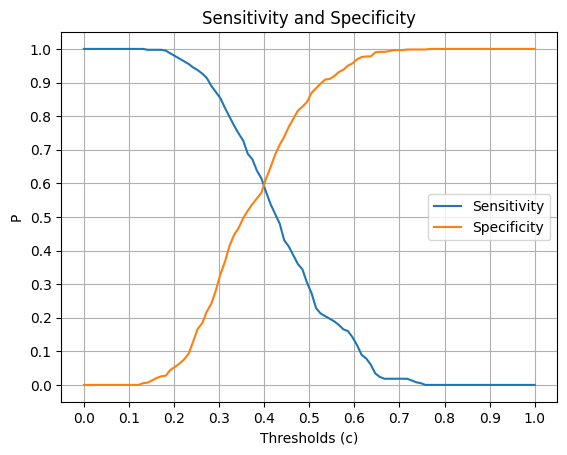

Threshold: 0.3131
Specificity at sensitivity 80%: 0.3677


In [51]:
from sklearn.metrics import confusion_matrix

specificity = []
sensitivity = []

thresholds = np.linspace(0, 1, 100)

for c in thresholds:
    y_pred = np.where(pr_model_pred[:Y.size] > c, 1, 0)
    tn, fp, fn, tp = confusion_matrix(y_pred=y_pred, y_true=Y).ravel()
    sensitivity.append(tp / (tp + fn))
    specificity.append(tn / (tn + fp))

plt.title('Sensitivity and Specificity')
plt.plot(thresholds, sensitivity, label="Sensitivity")
plt.plot(thresholds, specificity, label="Specificity")
plt.xlabel('Thresholds (c)')
plt.ylabel('P')

plt.legend()
plt.grid()

ticks = np.arange(0, 1.1, 0.1)
plt.xticks(ticks)
plt.yticks(ticks)

plt.show()

sensitivity = np.array(sensitivity)
specificity = np.array(specificity)

c = thresholds[sensitivity >= 0.8][-1]
spec_at_80 = specificity[sensitivity >= 0.8][-1]

print(f"Threshold: {c:.4f}")
print(f"Specificity at sensitivity 80%: {spec_at_80:.4f}")